# Motor position controller
In this section, the static motor controller will be created.

## External imports

In [6]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

## Internal imports

In [7]:
from src import *
from src.constants import DT

## Target trajectory

In [8]:
def sin_wave(amplitude: float, period: float):
    return amplitude * np.sin(np.linspace(-np.pi, np.pi, math.floor(period / DT)))

In [9]:
trajectory = np.zeros(1)
trajectory = np.concatenate((trajectory, 0. * np.ones(100)))
trajectory = np.concatenate((trajectory, 10. * np.ones(400)))
trajectory = np.concatenate((trajectory, 0. * np.ones(400)))
trajectory = np.concatenate((trajectory, -10. * np.ones(400)))
trajectory = np.concatenate((trajectory, 0. * np.ones(400)))
trajectory = np.concatenate((trajectory, 20. * np.ones(400)))
trajectory = np.concatenate((trajectory, 0. * np.ones(400)))
trajectory = np.concatenate((trajectory, -20. * np.ones(400)))
trajectory = np.concatenate((trajectory, 0. * np.ones(400)))
trajectory = np.concatenate((trajectory, 30. * np.ones(400)))
trajectory = np.concatenate((trajectory, 0. * np.ones(400)))
trajectory = np.concatenate((trajectory, -30. * np.ones(400)))
trajectory = np.concatenate((trajectory, 0. * np.ones(400)))
trajectory = np.concatenate((trajectory, 15. * np.ones(400)))
trajectory = np.concatenate((trajectory, 0. * np.ones(400)))
trajectory = np.concatenate((trajectory, -15. * np.ones(400)))
trajectory = np.concatenate((trajectory, 0. * np.ones(400)))

trajectory = np.concatenate((trajectory, sin_wave(20., 2.5)))
trajectory = np.concatenate((trajectory, sin_wave(20., 2.)))
trajectory = np.concatenate((trajectory, sin_wave(17., 1.5)))
trajectory = np.concatenate((trajectory, sin_wave(15., 1.5)))
trajectory = np.concatenate((trajectory, sin_wave(8., 1.)))
trajectory = np.concatenate((trajectory, sin_wave(7., 1.)))
trajectory = np.concatenate((trajectory, sin_wave(6., 0.75)))
trajectory = np.concatenate((trajectory, sin_wave(5., 0.75)))

trajectory = np.concatenate((trajectory, 0. * np.ones(50)))

<IPython.core.display.Javascript object>


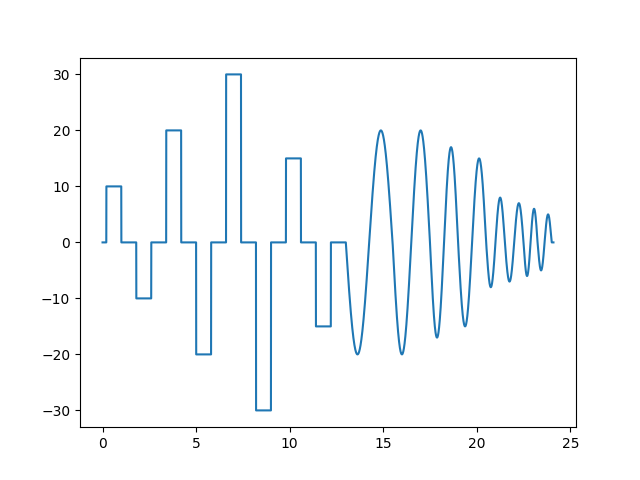

In [10]:
plt.plot(np.arange(0., len(trajectory) * DT, DT), trajectory)
plt.show()

## Controller

### Inputs
- error
- error²
- sign(error) * sqrt(error)
- d_error
- d_error²
- sign(d_error) * sqrt(d_error)
- integral_error
- integral_error²
- sign(integral_error) * sqrt(integral_error)

9 inputs
quadratic for better performance

### Output
- u

u: motor_input

### Architecture
FFW neural network [9, 9, 1]

## Training

In this section, the model template will be trained on the target trajectory.

### Optimisation

Genetic, survival of the fittest & matting + mutations.

In [ ]:
pid_controller = train_motor_controller(trajectory, 25, 20)
nn_controller = train_motor_controller(trajectory, 50, 20, controller_type='nn', hidden_size=10)

{'phy_coef': 2175.9587893981434, 'phy_i_coef_u': 2171.7632054282544, 'phy_i_coef_s': 7274.250340039839, 'speed_scaling': 20000}
Generation = 1
Fitness    = -1.8961494397716998
Generation = 2
Fitness    = -1.8489438597925696
Generation = 3
Fitness    = -1.7962697168864319
Generation = 4
Fitness    = -1.4267367588679702
Generation = 5
Fitness    = -1.3905533110896529
Generation = 6
Fitness    = -1.2683614025438577


## Testing
In this section, the best controller will be evaluated on the train data and test data

In [12]:
trajectory_test = np.concatenate((trajectory, 0. * np.ones(400)))
trajectory_test = np.concatenate((trajectory_test, 45. * np.ones(400)))
trajectory_test = np.concatenate((trajectory_test, 0. * np.ones(400)))
trajectory_test = np.concatenate((trajectory_test, -25. * np.ones(400)))
trajectory_test = np.concatenate((trajectory_test, 0. * np.ones(400)))

trajectory_test = np.concatenate((trajectory_test, sin_wave(40., 10)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(40., 5)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(30., 2)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(20., 1)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(10., 0.75)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(10., 0.75)))
trajectory_test = np.concatenate((trajectory_test, sin_wave(30., 2)))

In [13]:
evaluator: ModelEvaluator = ModelEvaluator(trajectory_test)
    
phy_history_pid, phy_error_pid, phy_u_pid, phy_loss_pid = evaluator.phy_simulate(pid_controller)
nn_history_pid, nn_error_pid, nn_u_pid, nn_loss_pid = evaluator.nn_simulate(pid_controller)

phy_history_nn, phy_error_nn, phy_u_nn, phy_loss_nn = evaluator.phy_simulate(nn_controller)
nn_history_nn, nn_error_nn, nn_u_nn, nn_loss_nn = evaluator.nn_simulate(nn_controller)

{'phy_coef': 2175.9587893981434, 'phy_i_coef_u': 2171.7632054282544, 'phy_i_coef_s': 7274.250340039839, 'speed_scaling': 20000}


<IPython.core.display.Javascript object>


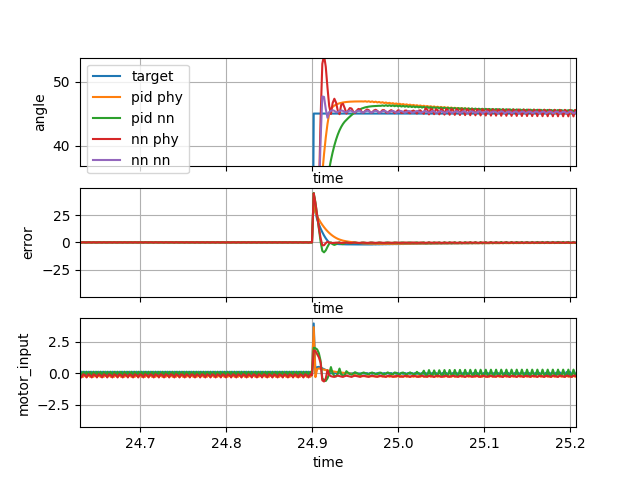

In [14]:
x = np.arange(0., len(trajectory_test) * DT, DT)

fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(x, trajectory_test, label='target')
axs[0].plot(x, phy_history_pid, label='pid phy')
axs[0].plot(x, nn_history_pid, label='pid nn')
axs[0].plot(x, phy_history_nn, label='nn phy')
axs[0].plot(x, nn_history_nn, label='nn nn')
axs[0].set_xlabel('time')
axs[0].set_ylabel('angle')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(x, phy_error_pid)
axs[1].plot(x, nn_error_pid)

axs[1].plot(x, phy_error_nn)
axs[1].plot(x, nn_error_nn)
axs[1].set_xlabel('time')
axs[1].set_ylabel('error')
axs[1].grid(True)

axs[2].plot(x, phy_u_pid)
axs[2].plot(x, nn_u_pid)
axs[2].plot(x, phy_u_nn)
axs[2].plot(x, nn_u_nn)
axs[2].set_xlabel('time')
axs[2].set_ylabel('motor_input')
axs[2].grid(True)


In [16]:
torch.save(pid_controller, 'src/data/motor_pid_controller.pt')
torch.save(nn_controller, 'src/data/motor_nn_controller.pt')